# Reproducing Omniglot experiment in the Siamese NNs for One Shot Recognition Paper

In this notebook we reproduce Table 1 in the original 
[Siamese NN Paper](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)

[Original MSc Thesis](http://www.cs.toronto.edu/~gkoch/files/msc-thesis.pdf).

We start from this [code](https://github.com/sorenbouma/keras-oneshot) implemented in Keras and try to translate it to use the PyTorch library



--------------------------------
# How/Why Siamese Networks Work


# One-Shot Image Recognition

# Experiment Setup

# Running the experiment on Google Colab

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

import os
from datetime import datetime, timedelta
from pytz import timezone

amsterdam = timezone('Europe/Amsterdam')
datetime_format = '%Y-%m-%d-T-(%H-%M-%S)'


-------------------------------------
## Definition of the netwok architecture

In [2]:
class ConvNet(nn.Module):
  """ Convolutional NN used in pair inside the siamese Network """
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 64, 10)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(64, 128, 7)
    self.conv3 = nn.Conv2d(128,128,4)
    self.conv4 = nn.Conv2d(128,256, 4)
    self.fc1 = nn.Linear(256*6*6, 4096)
  
  def forward(self, x):
    out = self.pool(F.relu(self.conv1(x)))
    out = self.pool(F.relu(self.conv2(out)))
    out = self.pool(F.relu(self.conv3(out)))
    out = F.relu(self.conv4(out))
    out = out.view(-1, 256*6*6)
    # We get the h feature vectors
    out = F.sigmoid(self.fc1(out))
    return out

class SiameseNet(nn.Module):
  """Siamese Net combining two ConvNets"""
  def __init__(self, net):
    # Receives a net as a parameter, we can just have 1 net 
    # but do the forward pass twice! and then just update once, much more 
    # elegant
    super(SiameseNet, self).__init__()
    # Instantiate two of the same class
    self.convnet = net
    # Final layer and output
    self.prediction_layer = nn.Linear(4096,1)

  def forward(self,x1, x2):
    """Computes the forward given two images"""
    h1 = self.convnet(x1)
    h2 = self.convnet(x2)
    h = self.calculate_l1_distance(h1, h2)
    out = F.sigmoid(self.prediction_layer(h))
    return out
  
  def calculate_l1_distance(self, h1, h2):
    """Calculates l1 distance between the two given vectors"""
    return torch.abs(h1-h2)


# How to initialize the weights according to the paper
def weights_init(model):
  if isinstance(model, nn.Conv2d):
    nn.init.normal_(model.weight, mean = 0.0, std = 1e-2)
    nn.init.normal_(model.bias, mean=0.5, std = 1e-2)
  elif isinstance(model, nn.Linear):
    nn.init.normal_(model.weight, mean= 0.0, std = 0.2)
    nn.init.normal_(model.bias, mean=0.5, std = 1e-2)



### Create the Siamese Network and Initialize weights according to specifications
- Conv layers: 
  - Weights: Normal(0, 1e-2)
  - Bias: Normal(0.5, 1e-2)
- Linear layers: 
  - Weights: Normal(0, 0.2)
  - Bias: Normal(0.5, 1e-2)

In [3]:
conv = ConvNet()
siamese = SiameseNet(conv)
siamese.apply(weights_init)

SiameseNet(
  (convnet): ConvNet(
    (conv1): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  )
  (prediction_layer): Linear(in_features=4096, out_features=1, bias=True)
)

### Define the Loss (CrossEntropy) and the Adam optimizer

In [4]:
import torch.optim as optim

# Learning rate decay per epoch
lr_decay_rate = 0.99
criterion = nn.BCELoss()

#optimizer = optim.SGD(siamese.parameters(), lr = 0.01, momentum=0.5, weight_decay=2e-4)
optimizer = optim.SGD(siamese.parameters(), lr = 0.1, weight_decay=2e-4)
optim_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma = lr_decay_rate)


---
## Hyperparameter Setting 

---
## Dataset

In [5]:
from torch.utils import data
import pickle
import numpy as np

In [6]:
class Dataset(data.Dataset):
  def __init__(self, data_path):
    """
    Parameters:
    -----------
    data_path: str
      Path to the pickle file
    """
    self.data = None
    self.alphabet_index = None
    with open(data_path, "rb") as f:
      X, i = pickle.load(f)
      self.data = X.astype("float32")
      self.alphabet_index = i

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    """
    Parameters:
    -----------
    index: int
      index from which to get the data
    """
    # get dimensions of the data
    num_letters, num_drawings, height, width = self.data.shape

    # initialize index2
    # index of second letter from pair same as first
    index2 = index

    # randomly choose a variant of the letter
    drawing_index = np.random.choice(num_drawings)
    drawing_index2 = np.random.choice(num_drawings)

    # choose image for first letter
    X1 = self.data[index, drawing_index, :, :].reshape(width, height)
    
    # set label to be 1, i.e. same letter
    y = np.array([1.0], dtype="float32")

    # with 50% probability,
    # pick an image of a different letter
    # and change the label to 0, i.e. different letter
    if np.random.uniform() >= 0.5:
      index2 = (index + np.random.randint(1, num_letters)) % num_letters
      y = np.array([0.0], dtype="float32")
    
    # choose image for the second letter
    X2 = self.data[index2, drawing_index2, :, :].reshape(width, height)

    return X1, X2, y

In [7]:
import os

# create the dataset object
data_path = "../../data/processed/"

train_set = Dataset(os.path.join(data_path, "train.pkl"))
eval_set = Dataset(os.path.join(data_path, "eval.pkl"))

device = torch.device('cuda')
siamese.to(device, dtype=torch.float32)

# set parameters for data creation
batch_size = 128
num_workers = 1

params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': num_workers}

# create the dataloader object which returns a generator over the data
train_generator = data.DataLoader(train_set, **params)
eval_generator = data.DataLoader(eval_set, **params)


---------------------------------
## Training and Validation

In [8]:
# create writer for tensorboard
from torch.utils.tensorboard import SummaryWriter 

dt = amsterdam.localize(datetime.now()).strftime(datetime_format)
logs_path = "./logs/" + dt + "/"
try:
    os.makedirs(save_path)
except:
    pass
writer = SummaryWriter(log_dir=logs_path, comment="Simese local testbench", flush_secs=1)

In [12]:
# create writer for tensorboard
from torch.utils.tensorboard import SummaryWriter 

dt = amsterdam.localize(datetime.now()).strftime(datetime_format)
logs_path = "./logs/" + dt + "/"
try:
    os.makedirs(save_path)
except:
    pass
writer = SummaryWriter(log_dir=logs_path, comment="Simese local testbench", flush_secs=1)


# run training
for epoch in range(200):
  running_loss = 0.0
  i = 0
  
  for X1, X2, y in train_generator:
    X1 = X1.to(device)
    X2 = X2.to(device)
    y = y.to(device)
    
    
    optimizer.zero_grad()

    X1 = X1.view(-1, 1, 105, 105)
    X2 = X2.view(-1, 1, 105, 105)
    

    outputs = siamese(X1, X2)
    # print(outputs, outputs.dtype)
    # print(outputs.shape)
    # print(y.shape)
    # print(outputs)
    # outputs_ = torch.cat((outputs.view(-1, 1), (1-outputs).view(-1, 1)), dim=1)
    loss = criterion(outputs , y)
    loss.backward()
    optimizer.step()


    # print statistics
    running_loss += loss.item()


    if i == 0:
      writer.add_scalar("training loss (per epoch)", loss.item(), epoch)
      writer.add_scalar("learning rate (per epoch)", optim_scheduler.state_dict()["_last_lr"][0], epoch)
    
    writer.add_scalar("training loss", loss.item(), epoch * len(train_generator) + i)

    print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / (i+1)))
    i+=1
  # Update the learning rate
  optim_scheduler.step()

  #
    
  


[101,     1] loss: 0.773
[101,     2] loss: 0.794
[101,     3] loss: 0.770
[101,     4] loss: 0.777
[101,     5] loss: 0.767
[101,     6] loss: 0.762
[101,     7] loss: 0.759
[101,     8] loss: 0.758
[102,     1] loss: 0.875
[102,     2] loss: 0.780
[102,     3] loss: 0.761
[102,     4] loss: 0.777
[102,     5] loss: 0.783
[102,     6] loss: 0.786
[102,     7] loss: 0.780
[102,     8] loss: 0.775
[103,     1] loss: 0.885
[103,     2] loss: 0.836
[103,     3] loss: 0.779
[103,     4] loss: 0.769
[103,     5] loss: 0.807
[103,     6] loss: 0.803
[103,     7] loss: 0.808
[103,     8] loss: 0.820
[104,     1] loss: 0.756
[104,     2] loss: 0.817
[104,     3] loss: 0.799
[104,     4] loss: 0.807
[104,     5] loss: 0.821
[104,     6] loss: 0.826
[104,     7] loss: 0.827
[104,     8] loss: 0.810
[105,     1] loss: 0.844
[105,     2] loss: 0.818
[105,     3] loss: 0.810
[105,     4] loss: 0.793
[105,     5] loss: 0.782
[105,     6] loss: 0.787
[105,     7] loss: 0.791
[105,     8] loss: 0.798


torch.Size([1, 105, 105])
torch.Size([1, 105, 105])
different letter


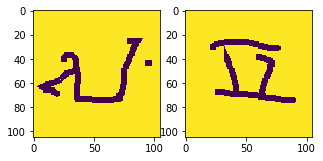

In [15]:
### Test to see if labels are correct

eval_set = Dataset(os.path.join(data_path, "eval.pkl"))

batch_size = 1
eval_generator = data.DataLoader(eval_set, **{'batch_size': batch_size})

import matplotlib.pyplot as plt

fig=plt.figure(figsize=(5, 5))
i=1
columns = 2
rows = batch_size
for x1, x2, y in eval_generator:
  print(x1.shape)
  print(x2.shape)
  fig.add_subplot(rows, columns, i)
  # img = np.random.randint(10, size=(h,w))
  plt.imshow(x1.squeeze())
  i+=1
  fig.add_subplot(rows, columns, i)
  plt.imshow(x2.squeeze())
  i+=1
  if (y == 1):
    print("same letter")
  else:
    print("different letter")
  break

plt.show()

---
## Running the Experiment

In [63]:
# Save the model
dt = amsterdam.localize(datetime.now()).strftime(datetime_format)
save_path = "./saves/" + dt + "/"
try:
    os.makedirs(save_path)
except:
    pass
torch.save(siamese, save_path + "siamese")